### ALBERT

BERT의 주요 문제점 중 하나는 수백만개의 변수로 구성되어 있다는 점이다.
**BERT-base는 1억 1천만 개의 변수**로 구성되어 있어서 모델 학습이 어렵고 추론 시 시간이 많이 걸린다.
모델 크기를 늘리면 성능은 좋아지지만, 계산 시 리소스가 많이 소모된다. 이 문제를 해결하기 위해 ALBERT를 도입하였다.
**ALBERT는 다음 두 가지 방법을 사용해 BERT와 대비해 변수를 적게 사용하게 되었고, 모델의 학습 시간과 추론 시간을 줄였다.**

- cross-layer parameter sharing
- factorized embedding layer parameterization

### cross-layer parameter sharing

bert는 N개의 인코더로 구성되어 있다. 예를 들어 BERT-base는 12개의 인코더 레이어로 구성되어 있다. 학습이 진행되면 인코더 레이어에 있는 모든 변수에 대해 학습이 이뤄진다.
하지만 cross-layer parameter sharing의 경우 모든 인코더 레이어의 변수를 학습시키는 것이 아니라
첫 번째 인코더 레이어의 변수만 학습한 다음 첫 번째 인코더 레이어의 변수를 다른 모든 인코더 레이어와 공유한다.

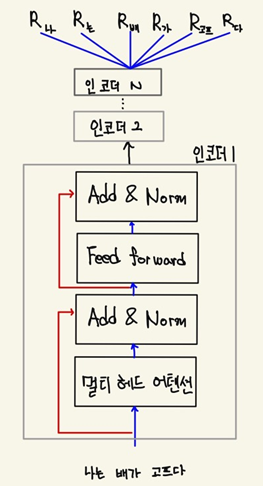

BERT에서 각각의 인코더 레이어는 동일한 형태를 가진다. 인코더 1의 변수를 학습시키고, 다른 모든 인코더와 변수를 공유하는 것을 크로스 레이어 변수 공유라고 한다. 계층 간에 변수를 공유하는 방법은 여러 가지가 있다.

- All-shared : 첫 번째 인코더의 하위 레이어에 있는 모든 변수를 나머지 인코더와 공유
- Shared feedforward network : 첫번째 인코더 레이어의 피드포워드 네트워크의 변수만 다른 인코더 레이어의 피드포워드 네트워크와 공유
- Shared attention : 첫 번째 인코더 레이어의 멀티 헤드 어텐션의 변수만 다른 인코더 레이어와 공유

그렇다면 Layer간 Parameter를 공유해도 과연 성능이 떨어지지 않을까 ?
아래표에서 처럼 Self-Attention Layer만 공유 했을 때는 성능이 크게 떨어지지않는다. 다만 Feed Forward Network(FFN)는 공유시 성능이 다소 떨어지는 것을 볼 수 있다. 논문에서는 실험 결과에 대한 해석은 하지 않고있다. (해보니까 좋더라.. 전형적인 딥러닝식 논문)
**어쨌든 Layer간 Parameter를 공유 한다고 하더라도 크게 성능이 떨어지지 않는다는 결과는 큰 의미가 있다.**

따라서 ALBERT는 BERT와 같은 layer수, Hidden size일지라도 모델의 크기가 훨 씬 작다.

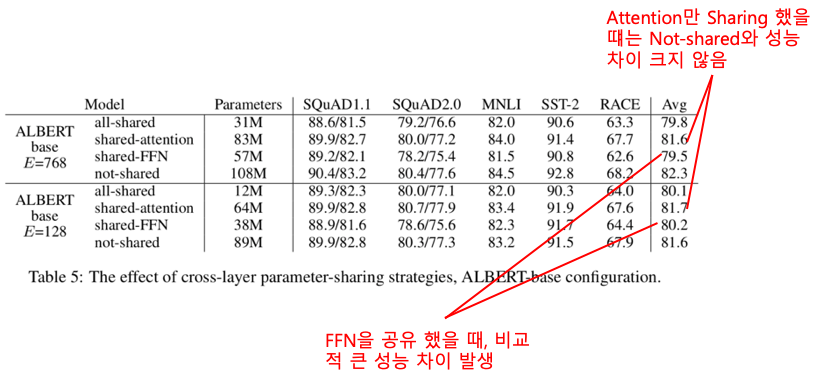

### factorized embedding layer parameterization

bert에서도 사용 되는 residual connection의 문제는 multihead attention에서 output과 input의 dimension이 같아야 된다는 것이다.
그렇기 때문에 처음에 input을 통과 시키는 embedding layer의 parameter를 학습시키기 위한 비용이 너무 많이 든다는 문제가 존재한다.

factorized embedding layer parameterization은 그러한 parameter를 최대한 줄이기 위해 도입되었으며, word 자체에 대한 정보를 담기 위해 실제로는 많은 차원이 필요하지 않다는 아이디어에서 출발하였다.

input 부분에서는 단어 자체를 embedding을 줄이기 위해 기존 embedding layer의 크기를 V x H에서 V x E 로 줄이고 이를 원래 input 차원으로 다시 늘려주기 위해 그 뒤에 E x H의 linear layer를 하나 더 둔다.

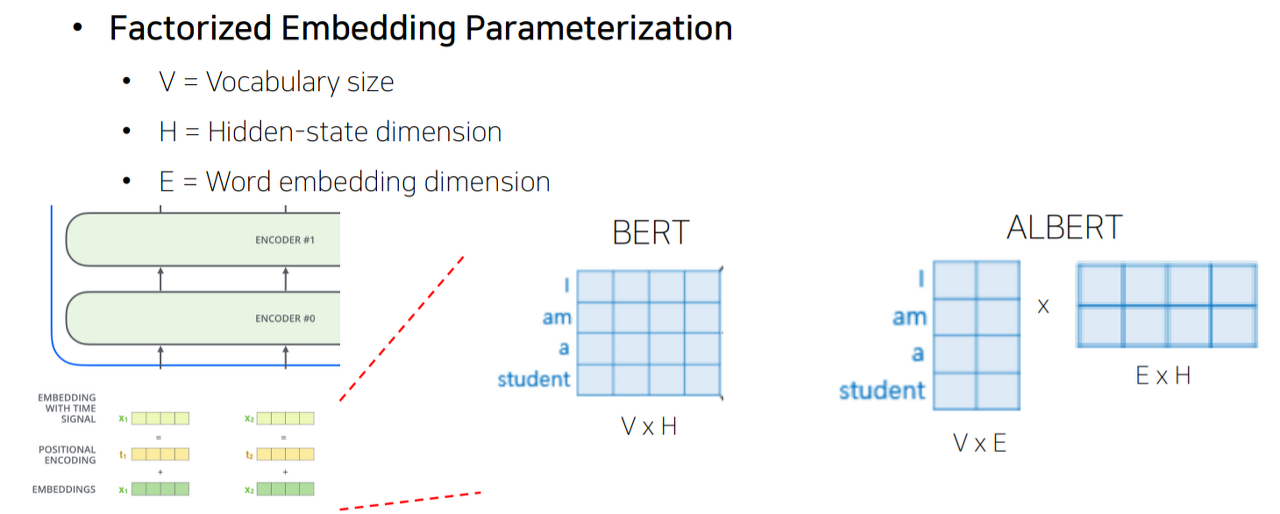

이렇게 하면 원래 word vector를 보통 768차원으로 두는데 E를 128정도로 두어 input단의 embedding layer의 paramter 개수를 V * H 에서 V * E + E * H로 대폭 줄일 수 있다. input단에서만 parameter를 줄여주면, self-attention 단계에서 학습시켜야하는 parameter수가 획기적으로 줄게 된다.이를 줄이는 것은 모델 전체의 사이즈를 줄이는데에 어느정도 기여할 수 있다.

### ALBERT 모델 학습

BERT의 경우 MLM과 NSP 태스크를 통해 사전 학습을 진행한다.
이와 유사하게 ALBERT의 모델은 MLM은 사용하지만, NSP 태스크 대신 sentence order prediction(SOP)를 사용한다.

기존 BERT 모델에서 학습 방법으로 채택한 Masking과 Next Sentence Prediction(NSP)중 NSP 방법의 경우 이후 연구에서 학습에 큰 도움을 주지 않는다는 점이 밝혀지면서, 이에 대한 대체 방안으로 Sentence Order Prediction(SOP)라는 방법이 제시 되었다.

#### 문장 순서 예측

NSP 태스크와 유사하게 SOP는 이진 분류 형태의 태스크다. NSP태스크는 한 쌍의 문장이 isNext 또는 notNext인지를 예측하는 형태로 학습이 이뤄진다. 하지만 SOP 태스크는 주어진 한쌍의 문장이 문장 순서가 바뀌었는지 여부를 예측하도록 모델 학습이 이뤄진다. 예제를 통해 좀 더 자세히 알아보자.

- 문장 1: 그는 김치볶음밥을 요리했다.
- 문장 2: 맛있었다.

주어진 한 쌍의 문장을 보면, 문장 2가 문장 1 다음에 온다는 것을 알 수 있다. 이때를 positive라고 한다.

- 문장 1: 맛있었다.
- 문장 2: 그는 김치볶음밥을 요리했다.

위 경우는 문장 순서가 바뀐 경우 이고 negetive이다.

따라서 SOP는 주어진 한 쌍의 문장이 positive인지 negative인지 분류하는 이진 분류 문제이다.

#### ALBERT vs BERT

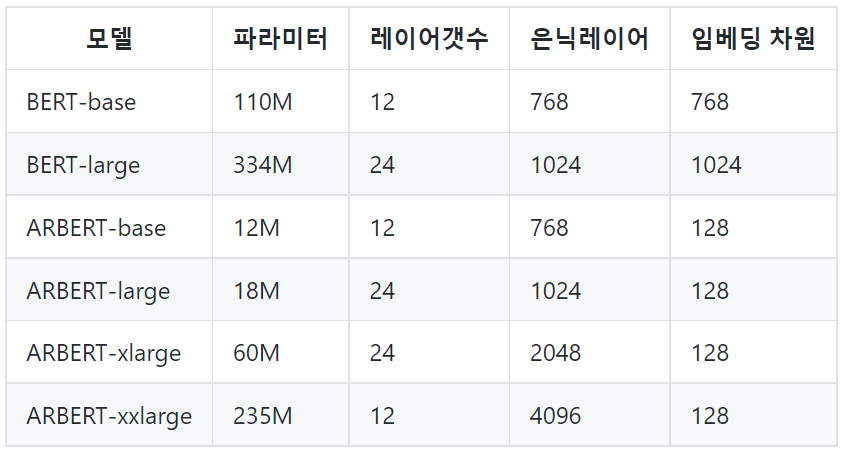

#### ALBEERT에서 임베딩 추출

In [19]:
from transformers import AlbertTokenizer, AlbertModel

model = AlbertModel.from_pretrained('albert-base-v2')
tokenizer =  AlbertTokenizer.from_pretrained('albert-base-v2')

#문장을 토크나이저에 입력해 필요한 입력값 반환
sentence = 'busan is a nice city'
#return_tensor ='pt' -> pytorch사용
inputs = tokenizer(sentence,return_tensors='pt')

ret = model(**inputs)
# hidden_rep, cls_head = model(**inputs)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


모델은 최종 인코더 레이어의 모든 토큰에 대한 hidden stats와 최종 인코더 레이어의 [CLS] 토큰에 대한 은닉 상태 표현인 cls head를 반환한다.

- hidden_rep[0][0] 는 [CLS] 토큰에 대한 임베딩 값이다.
- hidden_rep[0][1] 는 busan 토큰에 대한 임베딩 값이다.
- hidden_rep[0][6] 는 [SEP] 토큰에 대한 임베딩 값이다.

In [20]:
print(type(hidden_rep))

<class 'str'>


In [18]:
a = { 'first' : 1, 'second' : 2}
b, c = a
print(b, c)

first second


In [23]:
print(ret['last_hidden_state'].shape)

torch.Size([1, 8, 768])


In [25]:
print(ret['last_hidden_state'][0][1])

tensor([-8.4231e-01, -2.9251e-01,  9.6928e-01, -5.9271e-01,  7.4019e-01,
        -7.8544e-02,  9.2860e-02, -4.1467e-01,  2.6836e-01,  1.6879e+00,
         2.4872e-01, -1.6734e-01, -1.8856e-01,  7.7290e-01,  1.1350e-01,
        -1.0699e-01,  8.0881e-01, -6.7045e-01,  3.4467e-01,  6.8528e-01,
        -5.6162e-01,  2.9526e-01,  4.3792e-01,  9.8446e-01,  8.8589e-01,
         7.0147e-01, -5.8402e-01,  1.6738e+00,  3.7470e-01,  5.0017e-01,
        -1.3171e+00, -1.0856e+00, -7.1397e-01,  2.5742e-01, -6.5161e+00,
         2.8243e-03, -7.5781e-01, -3.6231e-01, -1.8396e-01,  2.3985e-01,
        -1.4706e+00,  5.5350e-01,  4.2941e-01, -4.6394e-01, -1.5179e+00,
         8.5464e-01, -9.5907e-01, -1.8848e-01,  1.2435e+00,  1.3890e+00,
         1.0858e+00,  1.1305e-01, -5.4768e-01, -3.7172e-01,  2.3983e-01,
         6.0166e-01, -1.3430e+00, -3.9671e-01, -7.9405e-01,  1.3561e+00,
         1.0680e+00, -1.1983e+00,  2.3816e-01,  1.4863e-01, -1.0461e+00,
        -2.9094e-01,  1.3637e+00, -9.2482e-01, -7.9

In [26]:
inputs 

{'input_ids': tensor([[   2, 1683,  210,   25,   21, 2210,  136,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [33]:
tokenizer.decode(inputs['input_ids'][0])

'busan is a nice city'

In [34]:
for data in inputs['input_ids'][0]:
    print(tokenizer.decode(data))

[CLS]
bus
an
is
a
nice
city
[SEP]


In [36]:
print(type(inputs['input_ids']))

<class 'torch.Tensor'>
